### Quantum Fisher Information matrix

<img src="others\qfim.png">

I have coded QFIM function and test it on 1qubit case

In [29]:
import qiskit
import numpy as np
import qtm.base_qtm, qtm.constant, qtm.qtm_1qubit
import matplotlib.pyplot as plt
from types import FunctionType


def create_QFIM(psi: np.ndarray, grad_psi: np.ndarray):
    """Create Quantum Fisher Information matrix base on 
    \n https://quantum-journal.org/views/qv-2021-10-06-61/
    
    Args:
        - psi (np.ndarray): Current state vector, is a N x 1 matrix
        - grad_psi (np.ndarray): All partial derivatives of $\psi$, is a N x N matrix

    Returns:
        np.ndarray: N x N matrix
    """
    num_params = grad_psi.shape[0]
    # Calculate elements \bra\psi|\partial_j \psi\ket
    F_elements = np.zeros(num_params, dtype = np.complex128)
    for i in range(num_params):
        F_elements[i] = np.transpose(np.conjugate(psi)).dot(grad_psi[i])
    # Calculate F[i, j] = 4*Re*[\bra\partial_i \psi | \partial_j \psi \ket - 
    # \bra\partial_i\psi | \psi\ket * \bra\psi|\partial_j \psi\ket]
    F = np.zeros([num_params, num_params])
    for i in range(0, num_params):
        for j in range(0, num_params):
            F[i, j] = 4*np.real(
                np.transpose(np.conjugate(grad_psi[i])).dot(grad_psi[j]) - 
                np.transpose(np.conjugate(F_elements[i]))*(F_elements[j]))
    return F

def grad_psi(
    qc: qiskit.QuantumCircuit, 
    create_circuit_func: FunctionType, 
    thetas: np.ndarray, r: float, s: float, **kwargs):
    """Return the derivatite of the psi base on parameter shift rule
    \n nabla\psi = frac{1}{2}(\psi(+s) - \psi(-s))

    Args:
        - qc (qiskit.QuantumCircuit): [description]
        - create_circuit_func (FunctionType): [description]
        - thetas (np.ndarray): [description]
        - r (float): in psr
        - s (float): in psr

    Returns:
        np.ndarray: N x N matrix
    """
    gradient_psi = np.zeros([len(thetas), 2**qc.num_qubits], dtype = np.complex128)
    for i in range(0, len(thetas)):
        thetas1, thetas2 = thetas.copy(), thetas.copy()
        thetas1[i] += s
        thetas2[i] -= s
        qc1 = create_circuit_func(qc.copy(), thetas1, **kwargs)
        qc2 = create_circuit_func(qc.copy(), thetas2, **kwargs)
        psi_qc1 = qiskit.quantum_info.Statevector.from_instruction(qc1).data
        psi_qc2 = qiskit.quantum_info.Statevector.from_instruction(qc2).data
        gradient_psi[i] = r*(psi_qc1 - psi_qc2)
    return gradient_psi

def qng(thetas: np.ndarray, psi: np.ndarray, grad_psi: np.ndarray, grad_loss: np.ndarray):
    """Update parameters based on quantum natural gradient algorithm
    \n thetas^{i + 1} = thetas^{i} - alpha * F^{-1} * nabla L

    Args:
        - thetas (np.ndarray): parameters
        - psi (np.ndarray): current state 
        - grad_psi (np.ndarray): all partial derivatives of $\psi$, is a N x N matrix
        - grad_loss (np.ndarray): gradient of loss function, is a N x 1 matrix

    Returns:
        np.ndarray: parameters after update
    """
    F = create_QFIM(psi, grad_psi)
    # Because det(QFIM) can be nearly equal zero
    inverse_F = np.linalg.pinv(F)
    thetas -= qtm.constant.learning_rate*np.dot(inverse_F, grad_loss)
    return thetas

def qng_adam(thetas: np.ndarray, 
    m: np.ndarray, v: np.ndarray, i: int, 
    psi: np.ndarray, grad_psi: np.ndarray, grad_loss: np.ndarray):
    """After calculating the QFIM, use it in Adam optimizer

    Args:
        - thetas (np.ndarray): parameters
        - m (np.ndarray): params for Adam
        - v (np.ndarray): params for Adam
        - i (int): params for Adam
        - psi (np.ndarray): current state 
        - grad_psi (np.ndarray): all partial derivatives of $\psi$, is a N x N matrix
        - grad_loss (np.ndarray): gradient of loss function, is a N x 1 matrix

    Returns:
        np.ndarray: parameters after update
    """
    F = create_QFIM(psi, grad_psi)
    inverse_F = np.linalg.pinv(F)
    grad = np.dot(inverse_F, grad_loss)
    thetas = qtm.base_qtm.adam(thetas, m, v, i, grad)
    return thetas

In [18]:
theta = np.random.uniform(0, np.pi)
phi = np.random.uniform(0, 2*np.pi)
# theta = np.pi/2
# phi = np.pi/4
lambdaz = 0

In [30]:
# Init quantum tomography 1 qubit
thetas = np.zeros((3,))
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
loss_values_qng = []
for i in range(0, 100):
    grad_psi1 = (grad_psi(qc, qtm.qtm_1qubit.u_1qubit, thetas, r = 1/2, s = np.pi/2))
    grad_loss = qtm.base_qtm.grad_loss(qc, qtm.qtm_1qubit.u_1qubit, thetas, r = 1/2, s = np.pi/2)
    qc_copy = qtm.qtm_1qubit.u_1qubit(qc.copy(), thetas, wire = 0)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc_copy).data
    # Create gradient of loss function
    # Quantum natural gradient
    thetas = qng(thetas, psi, grad_psi1, grad_loss)
    qc_copy2 = qtm.qtm_1qubit.u_1qubit(qc.copy(), thetas, wire = 0)
    loss = qtm.base_qtm.loss_basis(qtm.base_qtm.measure(qc_copy2, range(qc_copy2.num_qubits)))
    loss_values_qng.append(loss)

A (2.7755575615628914e-17+0.003562103754455155j)
A (2.7755575615628914e-17+0.003562103754455155j)
A (2.7755575615628914e-17+0.003562103754455155j)
A (-1.3877787807814457e-17-0.6735503715179091j)
A (-1.3877787807814457e-17-0.6735503715179091j)
A (-1.3877787807814457e-17-0.6735503715179091j)
A (2.7755575615628914e-17+0.003562103754455155j)
A (2.7755575615628914e-17+0.003562103754455155j)
A (2.7755575615628914e-17+0.003562103754455155j)
A (1.3877787807814457e-17+0.003562103754455273j)
A (1.3877787807814457e-17+0.003562103754455273j)
A (1.3877787807814457e-17+0.003562103754455273j)
A (6.245004513516506e-17-0.6739165774849909j)
A (6.245004513516506e-17-0.6739165774849909j)
A (6.245004513516506e-17-0.6739165774849909j)
A -0.0320060963905837j
A -0.0320060963905837j
A -0.0320060963905837j
A (-2.7755575615628914e-17+0.003562103754455266j)
A (-2.7755575615628914e-17+0.003562103754455266j)
A (-2.7755575615628914e-17+0.003562103754455266j)
A (5.551115123125783e-17-0.6650762741676505j)
A (5.5511151

In [20]:
# Init quantum tomography 1 qubit
thetas = np.zeros((3,))
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
loss_values_qng_adam = []
for i in range(0, 100):
    grad_psi1 = (grad_psi(qc, qtm.qtm_1qubit.u_1qubit, thetas, r = 1/2, s = np.pi/2))
    grad_loss = qtm.base_qtm.grad_loss(qc, qtm.qtm_1qubit.u_1qubit, thetas, r = 1/2, s = np.pi/2)
    qc_copy = qtm.qtm_1qubit.u_1qubit(qc.copy(), thetas, wire = 0)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc_copy).data
    # Create gradient of loss function
    # Quantum natural gradient
    if i == 0:
        m, v = list(np.zeros(thetas.shape[0])), list(np.zeros(thetas.shape[0]))
    thetas = qng_adam(thetas, m, v, i, psi, grad_psi1, grad_loss)
    qc_copy2 = qtm.qtm_1qubit.u_1qubit(qc.copy(), thetas, wire = 0)
    loss = qtm.base_qtm.loss_basis(qtm.base_qtm.measure(qc_copy2, range(qc_copy2.num_qubits)))
    loss_values_qng_adam.append(loss)

In [4]:

# Init quantum tomography 1 qubit
thetas = np.zeros((3,))
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
loss_values_qng = []
for i in range(0, 100):
    grad_psi1 = (grad_psi(qc, qtm.qtm_1qubit.u_1qubit, thetas, r = 1/2, s = np.pi/2))
    
    qc_copy = qtm.qtm_1qubit.u_1qubit(qc.copy(), thetas, wire = 0)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc_copy).data

    # Create F^-1
    F = create_QFIM(psi, grad_psi1)
    inverse_F = np.linalg.pinv(F)
    # Create gradient of loss function
    grad_loss = qtm.base_qtm.grad_loss(qc, qtm.qtm_1qubit.u_1qubit, thetas, r = 1/2, s = np.pi/2)
    # Quantum natural gradient
    thetas -= qtm.constant.learning_rate*np.dot(inverse_F, grad_loss)

    qc_copy2 = qtm.qtm_1qubit.u_1qubit(qc.copy(), thetas, wire = 0)
    loss = qtm.base_qtm.loss_basis(qtm.base_qtm.measure(qc_copy2, range(qc_copy2.num_qubits)))
    loss_values_qng.append(loss)



In [21]:
thetas = np.zeros((3,))
loss_values_sgd = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
# Reduce loss value in 100 steps
thetas, loss_values_sgd = qtm.base_qtm.fit(
    qc, num_steps = 100, thetas = thetas, 
    create_circuit_func = qtm.qtm_1qubit.u_1qubit, 
    grad_func = qtm.base_qtm.grad_loss,
    loss_func = qtm.base_qtm.loss_basis,
    optimizer = qtm.base_qtm.sgd,
    verbose = 1,
    wire = 0
)

Step: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


In [22]:
thetas = np.zeros((3,))
loss_values_adam = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
# Reduce loss value in 100 steps
thetas, loss_values_adam = qtm.base_qtm.fit(
    qc, num_steps = 100, thetas = thetas, 
    create_circuit_func = qtm.qtm_1qubit.u_1qubit, 
    grad_func = qtm.base_qtm.grad_loss,
    loss_func = qtm.base_qtm.loss_basis,
    optimizer = qtm.base_qtm.adam,
    verbose = 1,
    wire = 0
)

Step: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


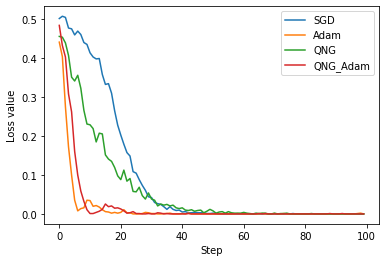

In [23]:
plt.show()
plt.plot(loss_values_sgd, label="SGD")
plt.plot(loss_values_adam, label="Adam")
plt.plot(loss_values_qng, label="QNG")
plt.plot(loss_values_qng_adam, label="QNG_Adam")
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.legend()
plt.show()